In [106]:
%matplotlib inline
from pylab import *
import random as rnd
import networkx as nx
from __future__ import division


def draw_graph(graph, graph_residual=None, labels=None, graph_layout='shell',
               node_size=3200, node_color='blue', node_alpha=0.3,
               node_text_size=24,
               edge_color='blue', edge_alpha=0.3,
               residual_color='red', residual_alpha=0.15, edge_tickness=2,
               edge_text_pos=0.6,
               text_font='sans-serif'):
    """ 
    Based on: https://www.udacity.com/wiki/creating-network-graphs-with-python
    """
    rcParams['figure.figsize'] = 24, 24 # that's default image size for this interactive session
    
    # these are different layouts for the network you may try
    # shell seems to work best
    if graph_layout == 'spring':
        graph_pos=nx.spring_layout(graph)
    elif graph_layout == 'spectral':
        graph_pos=nx.spectral_layout(graph)
    elif graph_layout == 'random':
        graph_pos=nx.random_layout(graph)
    else:
        graph_pos=nx.shell_layout(graph)

    # draw graph
    nx.draw_networkx_nodes(graph,graph_pos,node_size=node_size, 
                           alpha=node_alpha, node_color=node_color)
    nx.draw_networkx_edges(graph,graph_pos,width=edge_tickness,
                           alpha=edge_alpha,edge_color=edge_color)
    if graph_residual:
        nx.draw_networkx_edges(graph_residual,graph_pos,width=edge_tickness,
                               alpha=residual_alpha,edge_color=residual_color)
    nx.draw_networkx_labels(graph, graph_pos,font_size=node_text_size,
                            font_family=text_font)
    # show graph
    plt.show()

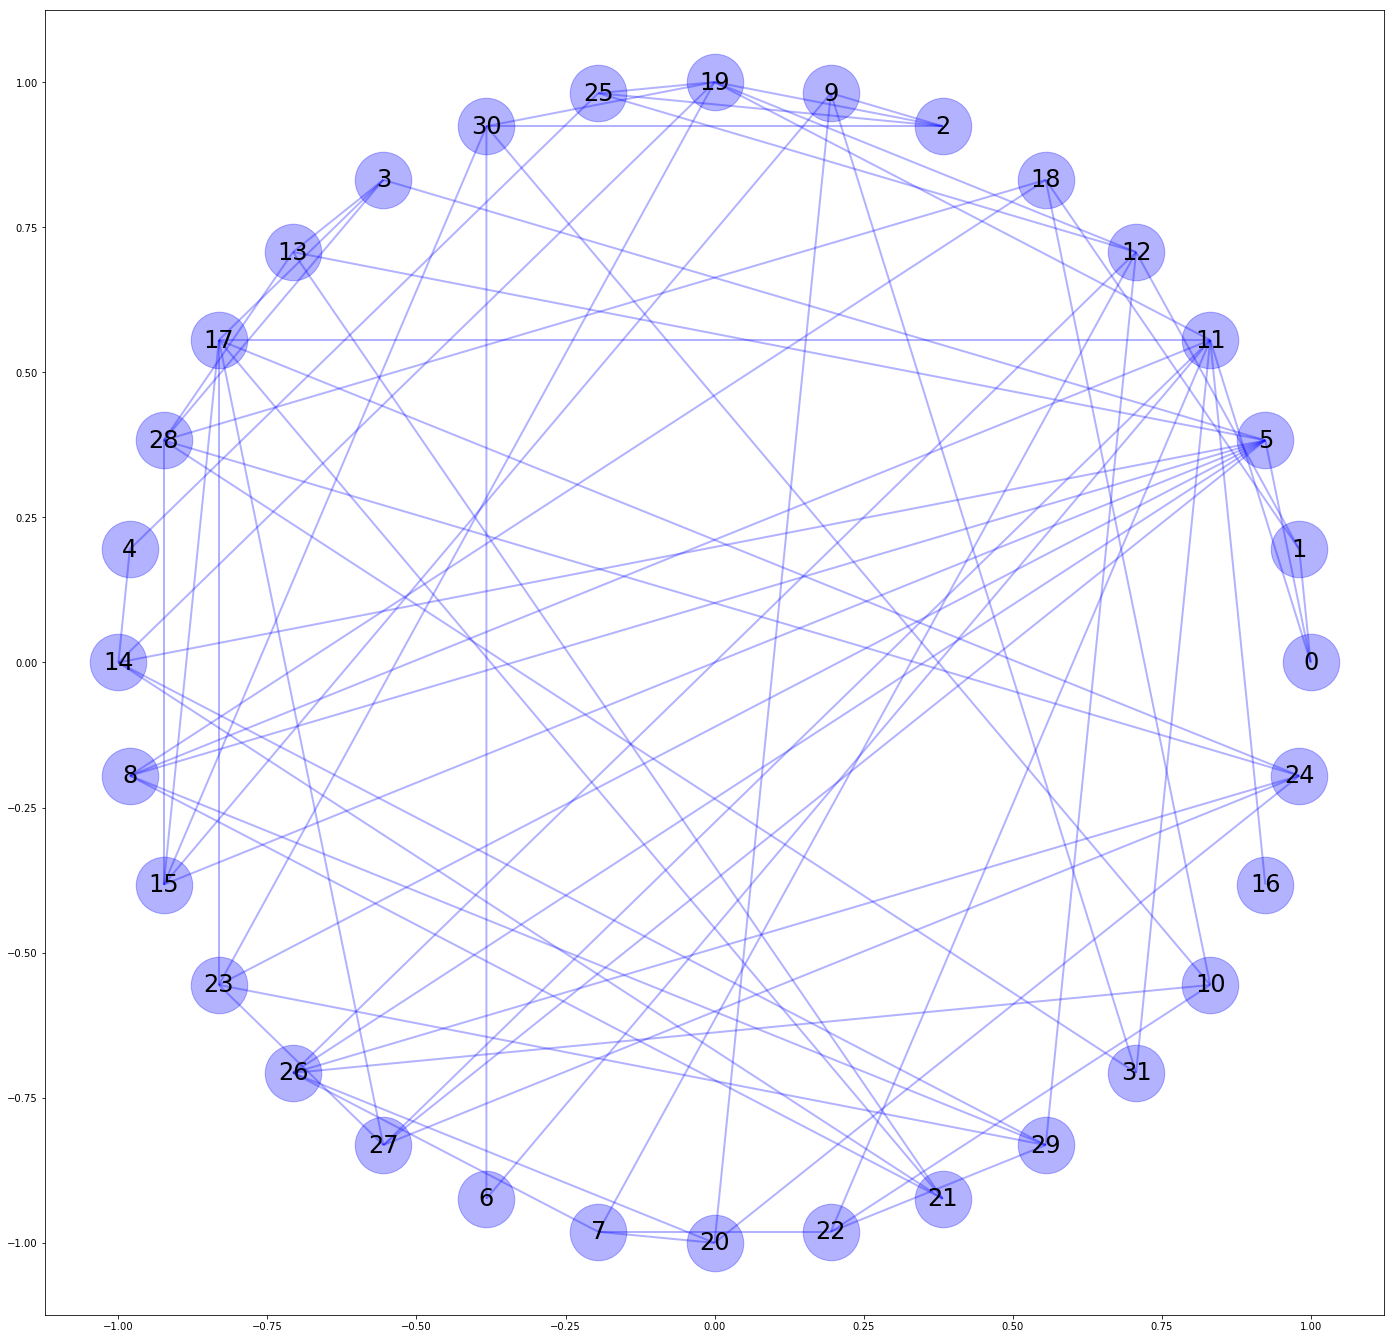

In [107]:
#seed = rnd.getrandbits(64)
#print('Seed = {}'.format(seed))
#rnd.seed(seed)
#rnd.seed(6566293948598230123)
rnd.seed(5031574397925273689)
TOTAL_V = 32
p = 5/32
G = nx.Graph()
G.add_edges_from([(x, y) for x in range(TOTAL_V) for y in range(x, TOTAL_V) if rnd.random() < p])
draw_graph(G)

In [108]:
rowdy = set()
for k, v in G.adj.items():
    l = list(v.keys())
    for i in range(len(l)-1):
        for j in range(i+1, len(l)):
            if k in G.adj[l[i]] and k in G.adj[l[j]] and l[i] in G.adj[l[j]] and k != l[i] and k != l[j]:
                rowdy.add(frozenset([k, l[i], l[j]]))
rowdy #not taken into account yet

{frozenset({7, 20, 26}),
 frozenset({12, 19, 25}),
 frozenset({11, 17, 27}),
 frozenset({5, 23, 27}),
 frozenset({3, 13, 28}),
 frozenset({7, 12, 26}),
 frozenset({17, 23, 27}),
 frozenset({2, 19, 25}),
 frozenset({17, 24, 27}),
 frozenset({2, 19, 30}),
 frozenset({20, 24, 26}),
 frozenset({3, 5, 13})}

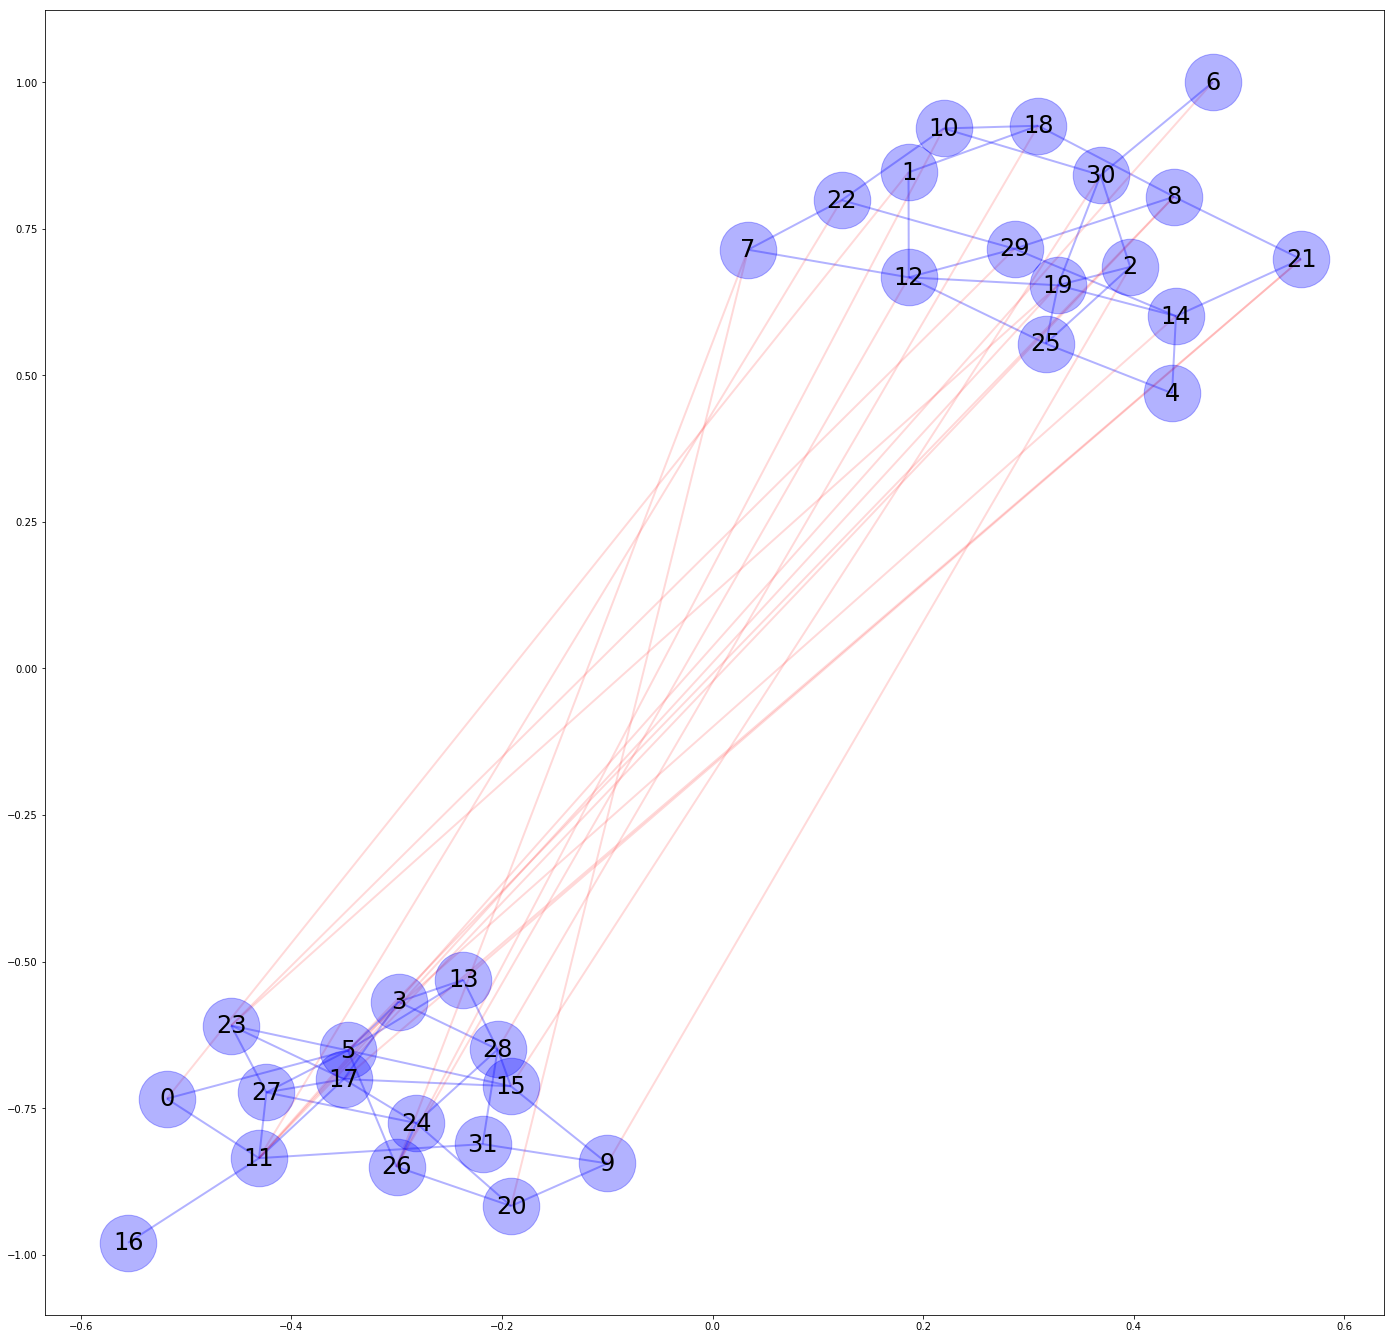

18 edges broken


In [109]:
from networkx.algorithms.community.kernighan_lin import kernighan_lin_bisection as kl_bisect
sub0, sub1 = kl_bisect(G, weight=None, seed=rnd.getrandbits(32))
sub0, sub1 = G.subgraph(sub0), G.subgraph(sub1)
split = nx.compose(sub0, sub1)
residual = nx.difference(G, split)
draw_graph(split, graph_residual=residual, graph_layout='spring')
print('{} edges broken'.format(len(residual.edges())))

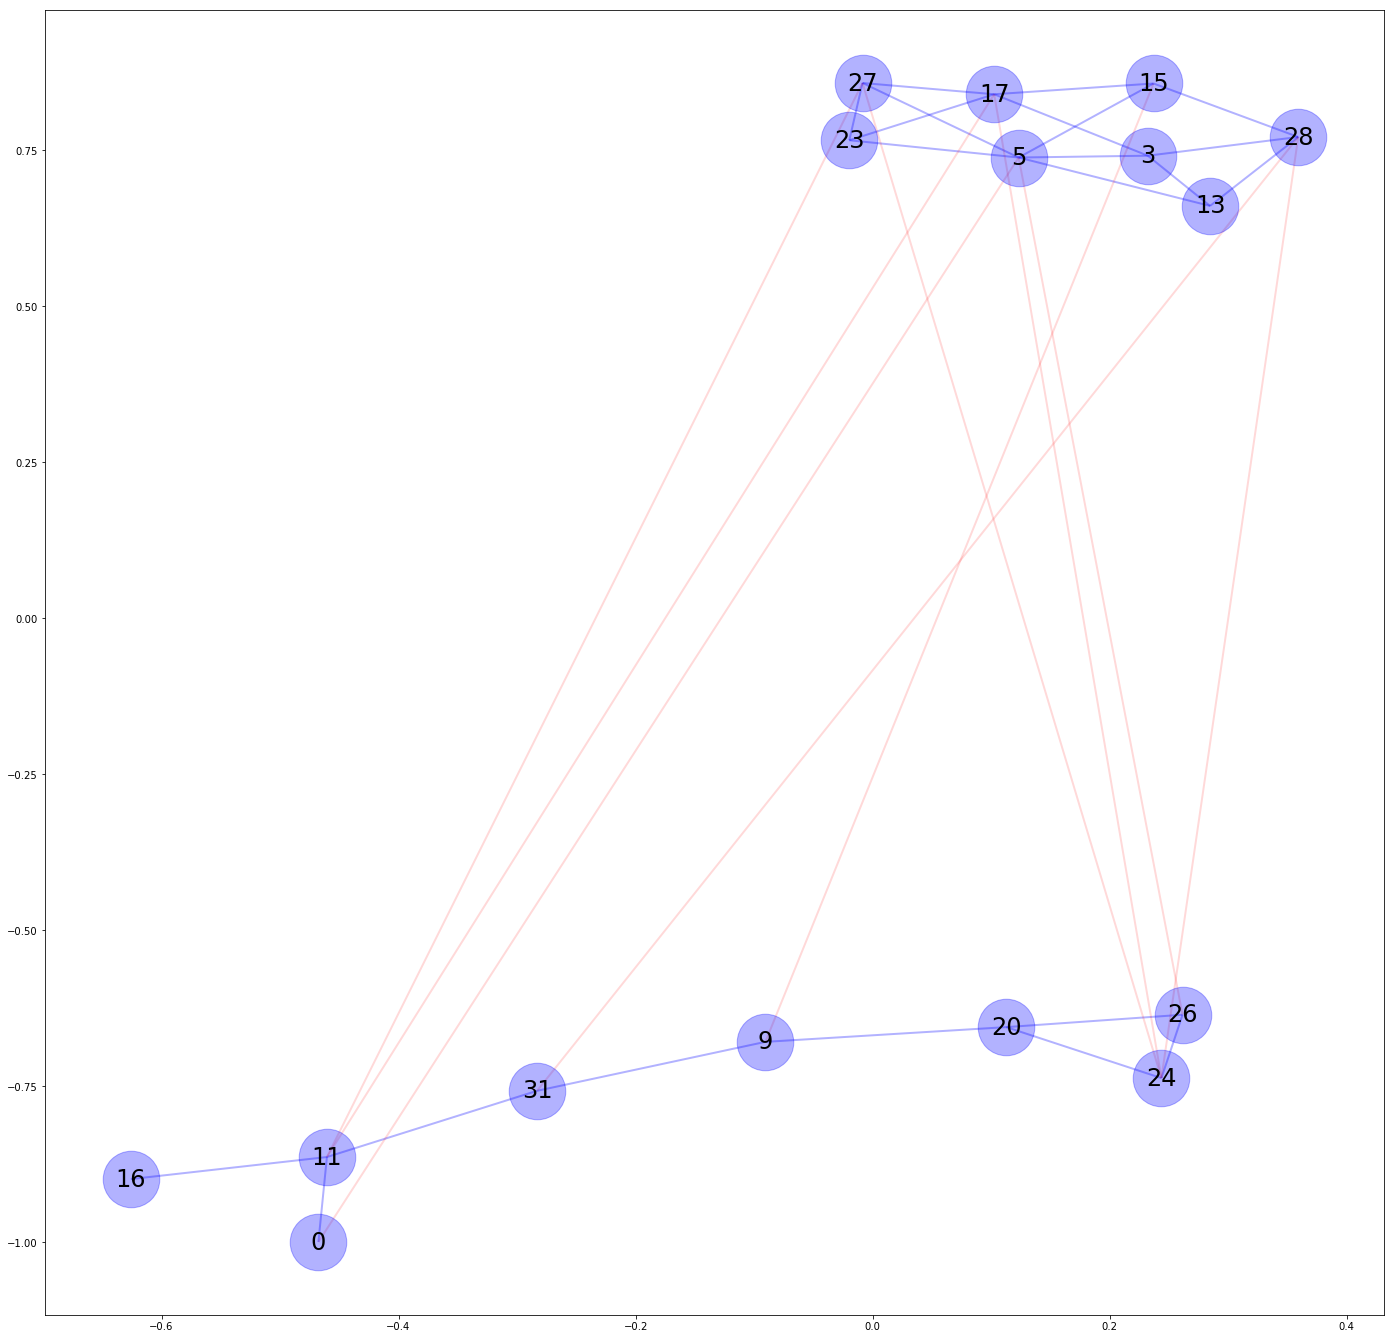

9 edges broken


In [110]:
sub00, sub01 = kl_bisect(sub0, weight=None, seed=rnd.getrandbits(32))
sub10, sub11 = kl_bisect(sub1, weight=None, seed=rnd.getrandbits(32))
sub00, sub01 = G.subgraph(sub00), G.subgraph(sub01)
split0 = nx.compose(sub00, sub01)
residual = nx.difference(sub0, split0)
draw_graph(split0, graph_residual=residual, graph_layout='spring')
print('{} edges broken'.format(len(residual.edges())))

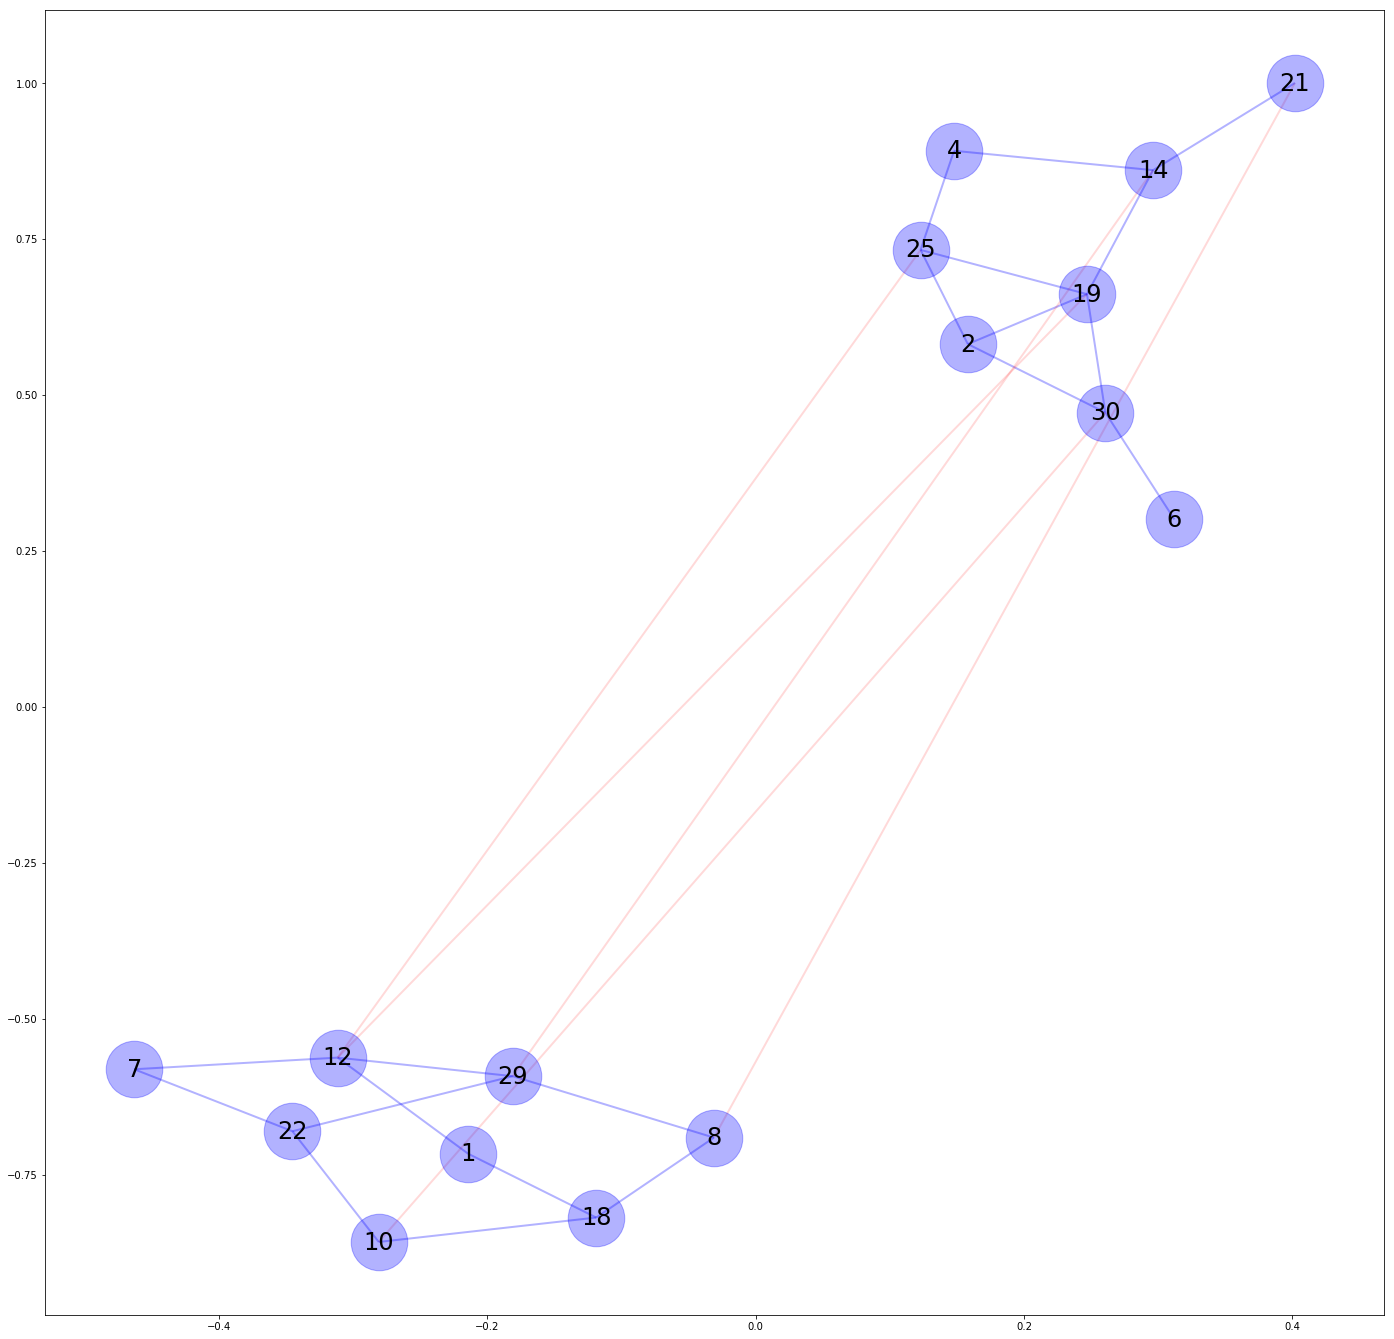

5 edges broken


In [111]:
sub10, sub11 = G.subgraph(sub10), G.subgraph(sub11)
split1 = nx.compose(sub10, sub11)
residual = nx.difference(sub1, split1)
draw_graph(split1, graph_residual=residual, graph_layout='spring')
print('{} edges broken'.format(len(residual.edges())))

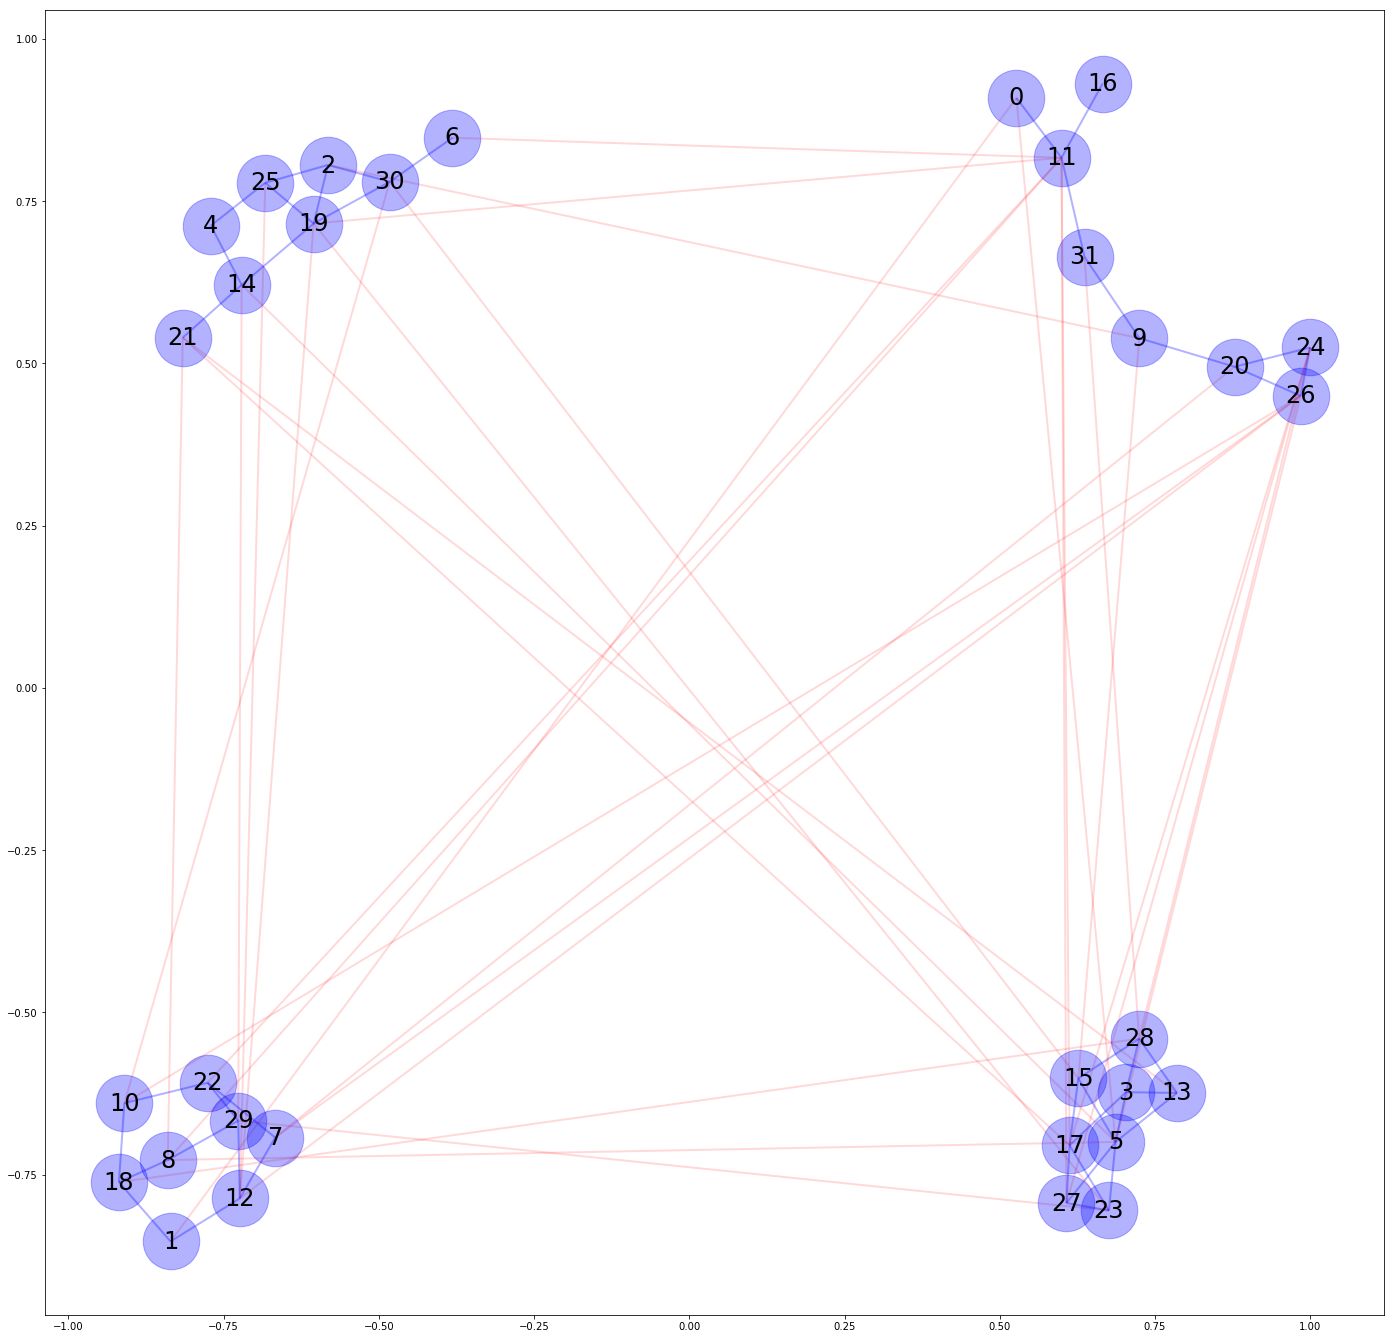

32 edges broken


In [112]:
split = nx.compose(split0, split1)
residual = nx.difference(G, split)
draw_graph(split, graph_residual=residual, graph_layout='spring')
print('{} edges broken'.format(len(residual.edges())))

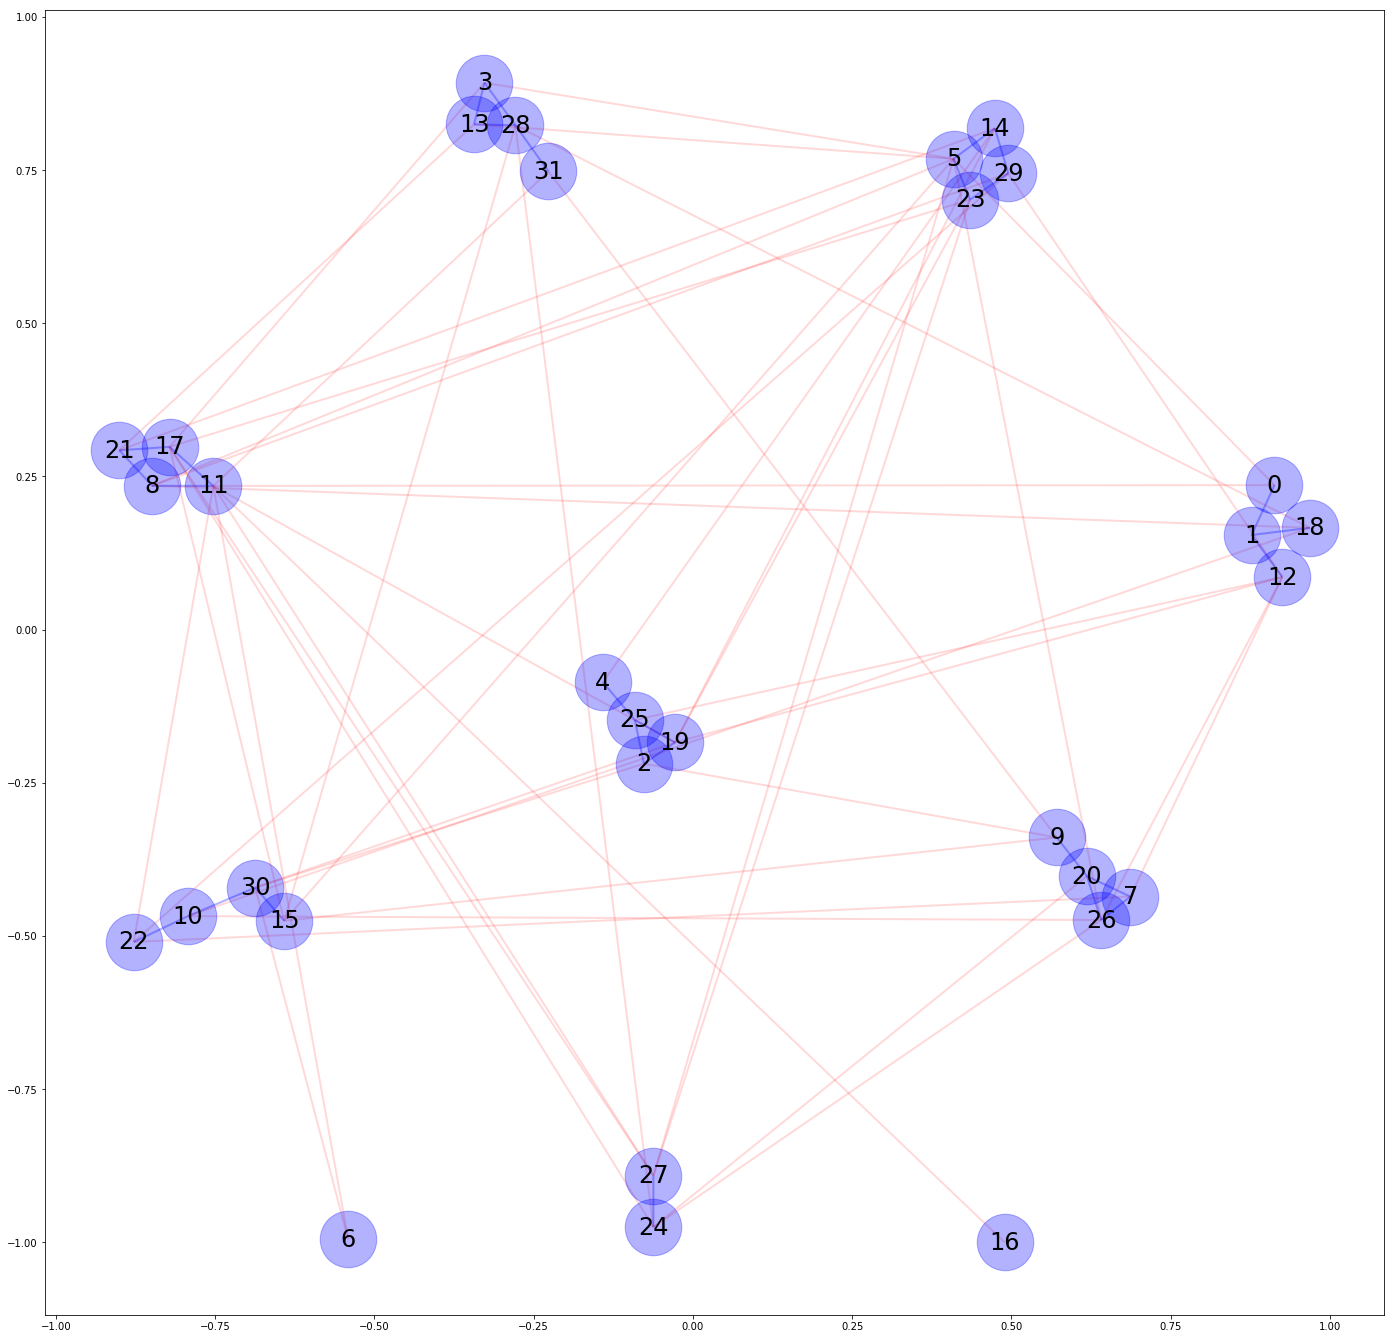

47 edges broken


In [114]:
import itertools
def kl_nsect(G, n):
    size = TOTAL_V // n
    sample = [i for i in range(TOTAL_V)]
    rnd.shuffle(sample)
    partitions = [set(sample[x: x+size]) for x in range(0, size*n, size)]
    combinations = list(itertools.combinations(range(n), 2))
    for c in combinations:
        G_sub = G.subgraph(partitions[c[0]].union(partitions[c[1]]))
        sub0, sub1 = kl_bisect(G_sub, partition=(partitions[c[0]], partitions[c[1]]), weight=None)
        partitions[c[0]], partitions[c[1]] = sub0, sub1
    return partitions

partitions = kl_nsect(G, 4)
subgraphs = [G.subgraph(p) for p in partitions]
split = nx.Graph()
for sg in subgraphs:
    split = nx.compose(split, sg)
residual = nx.difference(G, split)
draw_graph(split, graph_residual=residual, graph_layout='spring')
print('{} edges broken'.format(len(residual.edges())))